# Set environment

In [1]:
source("config_deseq.R")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following o

get the files from the star count files

In [2]:
# get files of all star output files
files <- list.files(DATDIR)

# get files from group B
outfiles <- grep("ReadsPerGene.out.tab$", files, value = TRUE)
print(outfiles)

 [1] "B_16_S26_L001_R1_short_introns_ReadsPerGene.out.tab"
 [2] "B_16_S26_L002_R1_short_introns_ReadsPerGene.out.tab"
 [3] "B_16_S26_L003_R1_short_introns_ReadsPerGene.out.tab"
 [4] "B_16_S26_L004_R1_short_introns_ReadsPerGene.out.tab"
 [5] "B_26_S10_L001_R1_short_introns_ReadsPerGene.out.tab"
 [6] "B_26_S10_L002_R1_short_introns_ReadsPerGene.out.tab"
 [7] "B_26_S10_L003_R1_short_introns_ReadsPerGene.out.tab"
 [8] "B_26_S10_L004_R1_short_introns_ReadsPerGene.out.tab"
 [9] "B_27_S18_L001_R1_short_introns_ReadsPerGene.out.tab"
[10] "B_27_S18_L002_R1_short_introns_ReadsPerGene.out.tab"
[11] "B_27_S18_L003_R1_short_introns_ReadsPerGene.out.tab"
[12] "B_27_S18_L004_R1_short_introns_ReadsPerGene.out.tab"
[13] "B_38_S34_L001_R1_short_introns_ReadsPerGene.out.tab"
[14] "B_38_S34_L002_R1_short_introns_ReadsPerGene.out.tab"
[15] "B_38_S34_L003_R1_short_introns_ReadsPerGene.out.tab"
[16] "B_38_S34_L004_R1_short_introns_ReadsPerGene.out.tab"
[17] "B_4_S2_L001_R1_short_introns_ReadsPerGene.out.tab"

# Import data

## 01 Metadata

In [3]:
mtdf <- readr::read_csv(METADTFILE)
mtdf <- mtdf %>% rename(Label = label, Media = media)

Parsed with column specification:
cols(
  label = col_character(),
  rna_sample_num = col_integer(),
  media = col_character(),
  Strain = col_character(),
  replicate = col_integer(),
  experiment_person = col_character(),
  group = col_character(),
  rin = col_double(),
  concentration_fold_difference = col_double(),
  `i7 primer` = col_character(),
  `i5 primer` = col_character(),
  `i7 index` = col_character(),
  `i5 index` = col_character(),
  `ng/ul` = col_integer()
)


In [4]:
head(mtdf)

Label,rna_sample_num,Media,Strain,replicate,experiment_person,group,rin,concentration_fold_difference,i7 primer,i5 primer,i7 index,i5 index,ng/ul
A_1,1,YPD,H99,1,expA,A,10.0,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_2,2,YPD,H99,2,expA,A,10.0,1.342821,i708,i501,TAATGCGC,AGGCTATA,2120
A_3,3,YPD,H99,3,expA,A,10.0,1.983167,i709,i501,CGGCTATG,AGGCTATA,1500
A_13,13,TC,H99,1,expA,A,10.0,1.953762,i710,i501,TCCGCGAA,AGGCTATA,1430
A_14,14,TC,H99,2,expA,A,10.0,1.569444,i711,i501,TCTCGCGC,AGGCTATA,1710
A_15,15,TC,H99,3,expA,A,9.9,2.847186,i712,i501,AGCGATAG,AGGCTATA,970


## 02 Read in the count data output from STAR

### Get a glance of the count data

In [5]:
cmdstr <- paste("head", file.path(DATDIR, outfiles[1]))
cmdout <- system(cmdstr, intern = TRUE)
str_split(cmdout, pattern = "\t")

[[1]]
[1] "N_unmapped" "9159"       "9159"       "9159"      

[[2]]
[1] "N_multimapping" "470249"         "470249"         "470249"        

[[3]]
[1] "N_noFeature" "469318"      "2453101"     "476341"     

[[4]]
[1] "N_ambiguous" "74495"       "212"         "423"        

[[5]]
[1] "CNAG_04548" "0"          "0"          "0"         

[[6]]
[1] "CNAG_07303" "0"          "0"          "0"         

[[7]]
[1] "CNAG_07304" "4"          "0"          "4"         

[[8]]
[1] "CNAG_00001" "0"          "0"          "0"         

[[9]]
[1] "CNAG_07305" "0"          "0"          "0"         

[[10]]
[1] "CNAG_00002" "25"         "0"          "25"

### Construct a matrix that gathers all the count files

In [6]:
mycombine <- function(df1, df2) {
    # Combine two data frames by gene names
    #
    # Args:
    #   df1 (Dataframe): the first count data
    #   df2 (Dataframe): the second count data
    #
    # Returns:
    #   (Dataframe) The combined data frame of df1 and df2
    full_join(df1, df2, by = "gene")
}

myfile <- function(filedir, filename) {
    # Get the absolute paths of a file
    #
    # Args:
    #   filedir  (Character): the directory of the folder
    #   filename (Character): the filename
    #
    # Returns:
    #   (Character) the directory of the input file
    file.path(filedir, filename)
}

# Data type for each column
coltypes <- list(col_character(), col_integer(), col_integer(), col_integer())

read the count files and combine them

In [7]:
out <- foreach(outfile = outfiles, .combine = mycombine) %do% {
    
    # get a directory of each count file
    cntfile <- file.path(DATDIR, outfile)
    
    # read in the count file
    readr::read_tsv(cntfile, col_names = FALSE, col_types = coltypes) %>%
        dplyr::select(X1, X4) %>% # get the 1st and 4th columns
            dplyr::rename_(.dots=setNames(names(.), c("gene", outfile)))
}

check output

In [8]:
dim(out)

[1] 8501   25

In [9]:
head(out, 10)

gene,B_16_S26_L001_R1_short_introns_ReadsPerGene.out.tab,B_16_S26_L002_R1_short_introns_ReadsPerGene.out.tab,B_16_S26_L003_R1_short_introns_ReadsPerGene.out.tab,B_16_S26_L004_R1_short_introns_ReadsPerGene.out.tab,B_26_S10_L001_R1_short_introns_ReadsPerGene.out.tab,B_26_S10_L002_R1_short_introns_ReadsPerGene.out.tab,B_26_S10_L003_R1_short_introns_ReadsPerGene.out.tab,B_26_S10_L004_R1_short_introns_ReadsPerGene.out.tab,B_27_S18_L001_R1_short_introns_ReadsPerGene.out.tab,⋯,B_38_S34_L003_R1_short_introns_ReadsPerGene.out.tab,B_38_S34_L004_R1_short_introns_ReadsPerGene.out.tab,B_4_S2_L001_R1_short_introns_ReadsPerGene.out.tab,B_4_S2_L002_R1_short_introns_ReadsPerGene.out.tab,B_4_S2_L003_R1_short_introns_ReadsPerGene.out.tab,B_4_S2_L004_R1_short_introns_ReadsPerGene.out.tab,B_40_S42_L001_R1_short_introns_ReadsPerGene.out.tab,B_40_S42_L002_R1_short_introns_ReadsPerGene.out.tab,B_40_S42_L003_R1_short_introns_ReadsPerGene.out.tab,B_40_S42_L004_R1_short_introns_ReadsPerGene.out.tab
N_unmapped,9159,8626,9416,9032,12335,11855,12603,12128,135943,⋯,21011,20597,1017930,998404,1023777,1006517,36532,35255,36591,36122
N_multimapping,470249,463192,469193,463449,988897,975103,986675,975201,235122,⋯,160959,159614,610733,601446,612603,599896,130184,128521,130261,128961
N_noFeature,476341,469769,479098,475947,205465,203273,206116,206384,858777,⋯,1044240,1040103,962478,947034,967261,952797,802513,795515,803866,797623
N_ambiguous,423,427,411,449,223,191,215,202,920,⋯,1382,1286,162,136,151,172,1232,1250,1386,1349
CNAG_04548,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,1,0
CNAG_07303,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_07304,4,5,6,2,2,0,0,0,2,⋯,0,5,1,1,0,1,5,5,9,6
CNAG_00001,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_07305,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,1
CNAG_00002,25,20,17,30,5,3,2,1,22,⋯,41,52,4,7,7,9,55,46,59,54


# Arrange the results from the count files

## 01 split the summary features (first four rows) from the gene counts

Summary features (first four rows)

In [10]:
### Gather and spread the first four rows
nmisc <- out %>%
    dplyr::slice(1:4) %>%
    gather(expid, value, -gene) %>% 
    spread(gene, value) %>%
    rename_(.dots = setNames(names(.), c("expid", "namb", "nmulti", "nnofeat","nunmap")))

nmisc %>% head

expid,namb,nmulti,nnofeat,nunmap
B_16_S26_L001_R1_short_introns_ReadsPerGene.out.tab,423,470249,476341,9159
B_16_S26_L002_R1_short_introns_ReadsPerGene.out.tab,427,463192,469769,8626
B_16_S26_L003_R1_short_introns_ReadsPerGene.out.tab,411,469193,479098,9416
B_16_S26_L004_R1_short_introns_ReadsPerGene.out.tab,449,463449,475947,9032
B_26_S10_L001_R1_short_introns_ReadsPerGene.out.tab,223,988897,205465,12335
B_26_S10_L002_R1_short_introns_ReadsPerGene.out.tab,191,975103,203273,11855


gene counts (remove the first four rows)

In [11]:
### remove the first four rows
dat <- out %>% dplyr::slice(-(1:4))

### convert from biological format to statistical format
genecounts <- dat %>% 
    column_to_rownames("gene") %>% 
    t %>% as.data.frame %>% 
    rownames_to_column("expid")

Warning message:
“Setting row names on a tibble is deprecated.”

In [12]:
genecounts[1:6, 1:6]

expid,CNAG_04548,CNAG_07303,CNAG_07304,CNAG_00001,CNAG_07305
B_16_S26_L001_R1_short_introns_ReadsPerGene.out.tab,0,0,4,0,0
B_16_S26_L002_R1_short_introns_ReadsPerGene.out.tab,0,0,5,0,0
B_16_S26_L003_R1_short_introns_ReadsPerGene.out.tab,0,0,6,0,1
B_16_S26_L004_R1_short_introns_ReadsPerGene.out.tab,0,0,2,0,0
B_26_S10_L001_R1_short_introns_ReadsPerGene.out.tab,0,0,2,0,0
B_26_S10_L002_R1_short_introns_ReadsPerGene.out.tab,0,0,0,0,0


## 02 Summarize the results

In [13]:
### Sum across the rows for a total gene count variable
ngene <- genecounts %>%    
    mutate(ngenemap = rowSums(.[-1])) %>%
    select(expid, ngenemap)

head(ngene)

expid,ngenemap
B_16_S26_L001_R1_short_introns_ReadsPerGene.out.tab,2057403
B_16_S26_L002_R1_short_introns_ReadsPerGene.out.tab,2027400
B_16_S26_L003_R1_short_introns_ReadsPerGene.out.tab,2065911
B_16_S26_L004_R1_short_introns_ReadsPerGene.out.tab,2041357
B_26_S10_L001_R1_short_introns_ReadsPerGene.out.tab,1844575
B_26_S10_L002_R1_short_introns_ReadsPerGene.out.tab,1817849


In [14]:
### Recall the summary features gotten from the count files
head(nmisc)

expid,namb,nmulti,nnofeat,nunmap
B_16_S26_L001_R1_short_introns_ReadsPerGene.out.tab,423,470249,476341,9159
B_16_S26_L002_R1_short_introns_ReadsPerGene.out.tab,427,463192,469769,8626
B_16_S26_L003_R1_short_introns_ReadsPerGene.out.tab,411,469193,479098,9416
B_16_S26_L004_R1_short_introns_ReadsPerGene.out.tab,449,463449,475947,9032
B_26_S10_L001_R1_short_introns_ReadsPerGene.out.tab,223,988897,205465,12335
B_26_S10_L002_R1_short_introns_ReadsPerGene.out.tab,191,975103,203273,11855


In [15]:
### Merge in the 4 misc counts and add summaries
mapresults <- ngene %>%
    full_join(nmisc, by = "expid") %>%
    mutate(depth       = as.integer(ngenemap + namb + nmulti + nnofeat + nunmap)) %>%
    mutate(prop.gene   = ngenemap / depth) %>%
    mutate(prop.nofeat = nnofeat / depth) %>%
    mutate(prop.unique = (ngenemap + nnofeat) / depth)

mapresults

expid,ngenemap,namb,nmulti,nnofeat,nunmap,depth,prop.gene,prop.nofeat,prop.unique
B_16_S26_L001_R1_short_introns_ReadsPerGene.out.tab,2057403,423,470249,476341,9159,3013575,0.6827117,0.15806509,0.8407768
B_16_S26_L002_R1_short_introns_ReadsPerGene.out.tab,2027400,427,463192,469769,8626,2969414,0.6827610,0.15820259,0.8409636
B_16_S26_L003_R1_short_introns_ReadsPerGene.out.tab,2065911,411,469193,479098,9416,3024029,0.6831651,0.15843036,0.8415954
B_16_S26_L004_R1_short_introns_ReadsPerGene.out.tab,2041357,449,463449,475947,9032,2990234,0.6826747,0.15916714,0.8418418
B_26_S10_L001_R1_short_introns_ReadsPerGene.out.tab,1844575,223,988897,205465,12335,3051495,0.6044824,0.06733257,0.6718150
B_26_S10_L002_R1_short_introns_ReadsPerGene.out.tab,1817849,191,975103,203273,11855,3008271,0.6042837,0.06757137,0.6718550
B_26_S10_L003_R1_short_introns_ReadsPerGene.out.tab,1852562,215,986675,206116,12603,3058171,0.6057745,0.06739845,0.6731730
B_26_S10_L004_R1_short_introns_ReadsPerGene.out.tab,1832915,202,975201,206384,12128,3026830,0.6055560,0.06818487,0.6737408
B_27_S18_L001_R1_short_introns_ReadsPerGene.out.tab,1547064,920,235122,858777,135943,2777826,0.5569334,0.30915435,0.8660877
B_27_S18_L002_R1_short_introns_ReadsPerGene.out.tab,1525294,961,232656,851671,134465,2745047,0.5556531,0.31025735,0.8659105


# Summarize lanes for each sample

## 01 Combine the summary results with the metadata from all lanes

Recall the information we have from metadata

In [16]:
head(mtdf)

Label,rna_sample_num,Media,Strain,replicate,experiment_person,group,rin,concentration_fold_difference,i7 primer,i5 primer,i7 index,i5 index,ng/ul
A_1,1,YPD,H99,1,expA,A,10.0,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_2,2,YPD,H99,2,expA,A,10.0,1.342821,i708,i501,TAATGCGC,AGGCTATA,2120
A_3,3,YPD,H99,3,expA,A,10.0,1.983167,i709,i501,CGGCTATG,AGGCTATA,1500
A_13,13,TC,H99,1,expA,A,10.0,1.953762,i710,i501,TCCGCGAA,AGGCTATA,1430
A_14,14,TC,H99,2,expA,A,10.0,1.569444,i711,i501,TCTCGCGC,AGGCTATA,1710
A_15,15,TC,H99,3,expA,A,9.9,2.847186,i712,i501,AGCGATAG,AGGCTATA,970


Check the label of samples

In [17]:
mapresults$expid %>% str_extract(., "^B_\\d*_\\w\\d*") %>% unique %>% sort

[1] "B_16_S26" "B_26_S10" "B_27_S18" "B_38_S34" "B_4_S2"   "B_40_S42"

In [18]:
mtdf$Label %>% str_extract(., "^B_\\d*") %>% na.omit %>% sort

[1] "B_16" "B_26" "B_27" "B_38" "B_4"  "B_40"

Store the regular expresssion pattern

In [19]:
myregex <- "^B_\\d*"

Add "Label" to map results and join with metadata

In [20]:
annomapres <- mapresults %>%
    mutate(Label = str_extract(expid, myregex)) %>%
    left_join(., mtdf, by = "Label")

head(annomapres)

expid,ngenemap,namb,nmulti,nnofeat,nunmap,depth,prop.gene,prop.nofeat,prop.unique,⋯,replicate,experiment_person,group,rin,concentration_fold_difference,i7 primer,i5 primer,i7 index,i5 index,ng/ul
B_16_S26_L001_R1_short_introns_ReadsPerGene.out.tab,2057403,423,470249,476341,9159,3013575,0.6827117,0.15806509,0.8407768,⋯,4,expA,B,10,3.009533,i710,i502,TCCGCGAA,GCCTCTAT,920
B_16_S26_L002_R1_short_introns_ReadsPerGene.out.tab,2027400,427,463192,469769,8626,2969414,0.6827610,0.15820259,0.8409636,⋯,4,expA,B,10,3.009533,i710,i502,TCCGCGAA,GCCTCTAT,920
B_16_S26_L003_R1_short_introns_ReadsPerGene.out.tab,2065911,411,469193,479098,9416,3024029,0.6831651,0.15843036,0.8415954,⋯,4,expA,B,10,3.009533,i710,i502,TCCGCGAA,GCCTCTAT,920
B_16_S26_L004_R1_short_introns_ReadsPerGene.out.tab,2041357,449,463449,475947,9032,2990234,0.6826747,0.15916714,0.8418418,⋯,4,expA,B,10,3.009533,i710,i502,TCCGCGAA,GCCTCTAT,920
B_26_S10_L001_R1_short_introns_ReadsPerGene.out.tab,1844575,223,988897,205465,12335,3051495,0.6044824,0.06733257,0.6718150,⋯,8,expB,B,10,2.758416,i708,i502,TAATGCGC,GCCTCTAT,1010
B_26_S10_L002_R1_short_introns_ReadsPerGene.out.tab,1817849,191,975103,203273,11855,3008271,0.6042837,0.06757137,0.6718550,⋯,8,expB,B,10,2.758416,i708,i502,TAATGCGC,GCCTCTAT,1010


summarize results from all lanes

In [21]:
colnames(annomapres)

[1] "expid"                         "ngenemap"                     
 [3] "namb"                          "nmulti"                       
 [5] "nnofeat"                       "nunmap"                       
 [7] "depth"                         "prop.gene"                    
 [9] "prop.nofeat"                   "prop.unique"                  
[11] "Label"                         "rna_sample_num"               
[13] "Media"                         "Strain"                       
[15] "replicate"                     "experiment_person"            
[17] "group"                         "rin"                          
[19] "concentration_fold_difference" "i7 primer"                    
[21] "i5 primer"                     "i7 index"                     
[23] "i5 index"                      "ng/ul"

In [22]:
grpvars <- vars(Label, Strain, Media, experiment_person)
sumvars <- vars(prop.gene, prop.nofeat, prop.unique, depth)

annomapres0 <- annomapres %>%
    group_by_at(grpvars) %>%
    summarize_at(sumvars, mean)

In [24]:
annomapres0

Label,Strain,Media,experiment_person,prop.gene,prop.nofeat,prop.unique,depth
B_16,H99,TC,expA,0.6828281,0.15846630,0.8412944,2999313
B_26,H99,YPD,expB,0.6050241,0.06762182,0.6726459,3036192
B_27,H99,YPD,expB,0.5561692,0.30984824,0.8660174,2766512
B_38,H99,TC,expB,0.5773448,0.35963998,0.9369848,2889270
B_4,H99,YPD,expA,0.1630784,0.31112660,0.4742050,3077208
B_40,H99,TC,expB,0.6519713,0.28794455,0.9399158,2777946


## 02 Combine the count for each sample from all lanes

Add "Label" to genecounts

In [25]:
annogenecnts <- genecounts %>% mutate(Label = str_extract(expid, myregex))

In [26]:
head(annogenecnts[1:6, c(1:4, ncol(annogenecnts))])

expid,CNAG_04548,CNAG_07303,CNAG_07304,Label
B_16_S26_L001_R1_short_introns_ReadsPerGene.out.tab,0,0,4,B_16
B_16_S26_L002_R1_short_introns_ReadsPerGene.out.tab,0,0,5,B_16
B_16_S26_L003_R1_short_introns_ReadsPerGene.out.tab,0,0,6,B_16
B_16_S26_L004_R1_short_introns_ReadsPerGene.out.tab,0,0,2,B_16
B_26_S10_L001_R1_short_introns_ReadsPerGene.out.tab,0,0,2,B_26
B_26_S10_L002_R1_short_introns_ReadsPerGene.out.tab,0,0,0,B_26


convert from statistical format to biological format

In [27]:
### summarize all the lane by sum
dat <- annogenecnts %>%
    select(-expid) %>%
    group_by(Label) %>%
    summarize_all(sum)

### put the first column to the rownames for transpose
dat <- dat %>% column_to_rownames("Label") 

### transpose
dat <- dat %>% t %>% as.data.frame

### add the gene name from row name to the first column
dat <- dat %>% rownames_to_column("gene")

annogenecnts0 <- dat

Warning message:
“Setting row names on a tibble is deprecated.”

In [28]:
head(annogenecnts0)

gene,B_16,B_26,B_27,B_38,B_4,B_40
CNAG_04548,0,0,0,1,0,1
CNAG_07303,0,0,0,0,0,0
CNAG_07304,17,2,7,15,3,25
CNAG_00001,0,0,0,0,0,0
CNAG_07305,1,0,0,1,0,2
CNAG_00002,92,11,98,173,27,214


# Store the results

In [29]:
cat(OUTDIR)

/shared_space/TA_clint/analysis_output/out

In [30]:
outfile <- file.path(OUTDIR, "HTS-GroupB-Annotated-STAR-counts.RData")
save(mtdf, annogenecnts0, annomapres0, annogenecnts, annomapres, file = outfile)
tools::md5sum(outfile)

/shared_space/TA_clint/analysis_output/out/HTS-GroupB-Annotated-STAR-counts.RData 
                                               "1f5046c21ea870ac409bd157d8edbc4c"

# Visualizing the summary features for each sample

In [50]:
### Figures for mapping results
options(repr.plot.width = 9, repr.plot.height = 4)
mygeom <-  geom_point(position = position_jitter(w = 0.3, h = 0))
mypal <- scale_colour_manual(name="",  values =brewer.pal(3,"Set1"))
mytheme <-  theme(axis.text.x = element_text(angle = 90, hjust = 1)) + theme_bw()
myfacet <- facet_grid(Strain~ Media, drop=TRUE, scales="free_x", space="free")

In [41]:
mtdf[grepl("^B", mtdf$Label),]

Label,rna_sample_num,Media,Strain,replicate,experiment_person,group,rin,concentration_fold_difference,i7 primer,i5 primer,i7 index,i5 index,ng/ul
B_4,4,YPD,H99,4,expA,B,10.0,2.047081,i707,i502,CTGAAGCT,GCCTCTAT,1490
B_26,26,YPD,H99,8,expB,B,10.0,2.758416,i708,i502,TAATGCGC,GCCTCTAT,1010
B_27,27,YPD,H99,9,expB,B,10.0,3.569259,i709,i502,CGGCTATG,GCCTCTAT,270
B_16,16,TC,H99,4,expA,B,10.0,3.009533,i710,i502,TCCGCGAA,GCCTCTAT,920
B_38,38,TC,H99,8,expB,B,9.3,2.438115,i711,i502,TCTCGCGC,GCCTCTAT,244
B_40,40,TC,H99,10,expB,B,9.9,3.636538,i712,i502,AGCGATAG,GCCTCTAT,520


### Show the fraction of unique mapped reads among all reads (prop.unique)

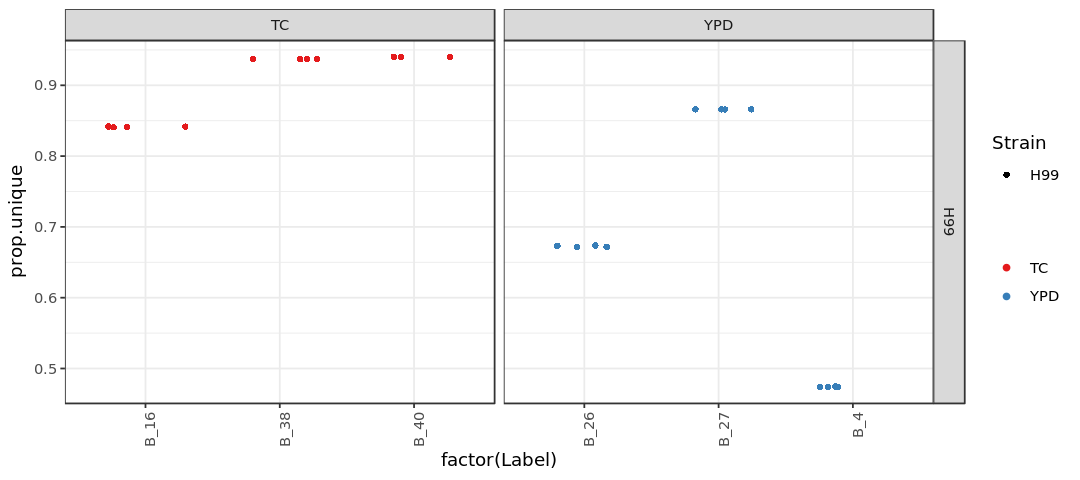

In [35]:
p1 <- ggplot(annomapres, 
             aes(x = factor(Label), 
                 y = prop.unique, 
                 shape = Strain, 
                 color = Media)) +
        myfacet + 
        mygeom + 
        mytheme + 
        mypal

print(p1)

### Show the fraction of reads mapped to genes (prop.gene)

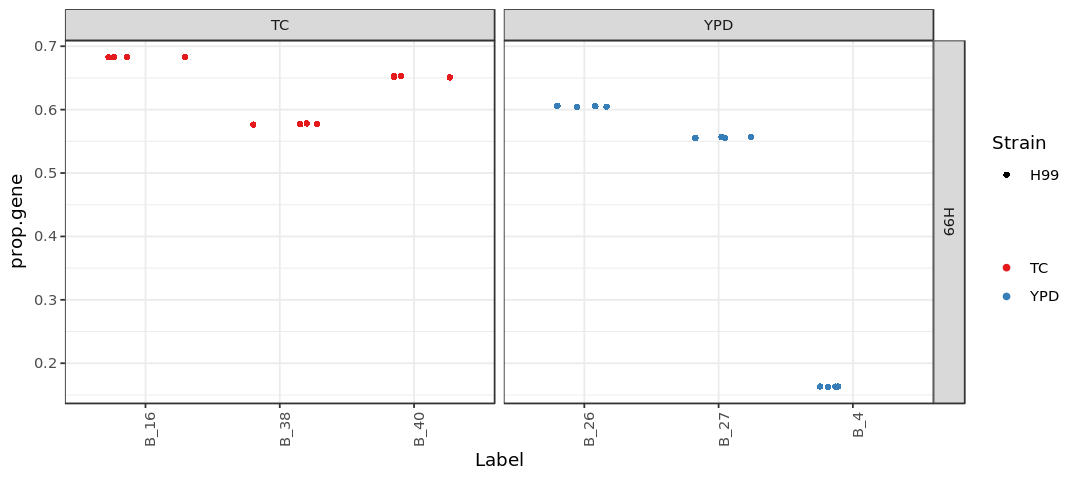

In [43]:
p2 <- ggplot(annomapres, 
             aes(x = Label, 
                 y = prop.gene, 
                 shape = Strain, 
                 color = Media)) +
        myfacet +
        mygeom +
        mytheme + 
        mypal
  
print(p2)

### Show the fraction of reads categorized as "no feature" (prop.nofeat)

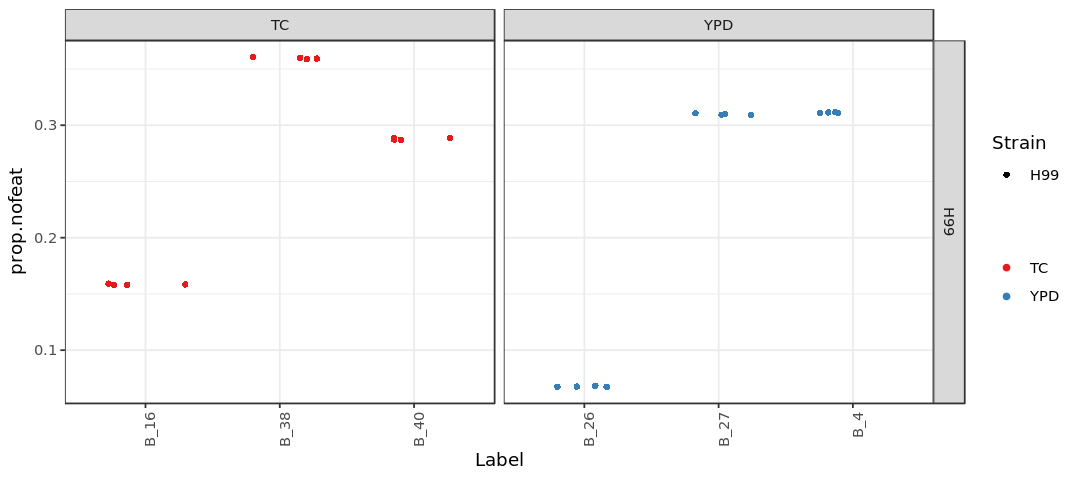

In [45]:
p3 <- ggplot(annomapres, 
             aes(x = Label, 
                 y = prop.nofeat, 
                 shape = Strain, 
                 color = Media))+
        myfacet +
        mygeom + 
        mytheme + 
        mypal

print(p3)

### Show the number of all the reads in each sample 
(Note: depth = ngenemap + namb + nmulti + nnofeat + nunmap)

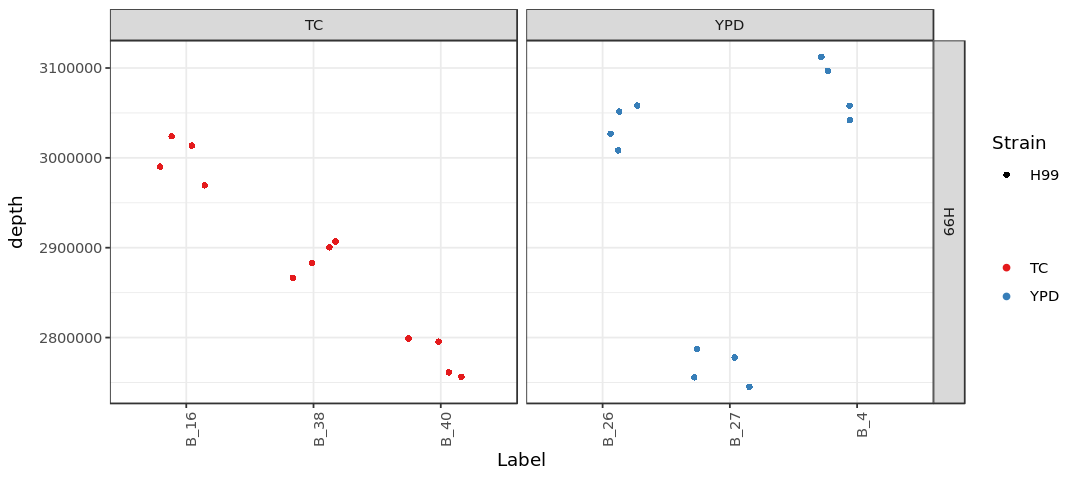

In [51]:
p4 <- ggplot(annomapres, 
             aes(x = Label, 
                 y = depth, 
                 shape = Strain, 
                 color = Media))+
        myfacet +
        mygeom +
        mytheme +
        mypal

print(p4)

### Store the plots

In [47]:
png(file.path(IMGDIR, "p1.png"), height = 480 * 1, width = 480 * 2)
plot(p1)
graphics.off()

png(file.path(IMGDIR, "p2.png"), height = 480 * 1, width = 480 * 2)
plot(p2)
graphics.off()

png(file.path(IMGDIR, "p3.png"), height = 480 * 1, width = 480 * 2)
plot(p3)
graphics.off()

png(file.path(IMGDIR, "p4.png"), height = 480 * 1, width = 480 * 2)
plot(p4)
graphics.off()

In [48]:
dir(IMGDIR)

[1] "p1.png" "p2.png" "p3.png" "p4.png"

# The End

In [49]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

Matrix products: default
BLAS: /opt/conda/lib/R/lib/libRblas.so
LAPACK: /opt/conda/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] tools     parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2               plotly_4.8.0              
 [3] dendextend_1.8.0           gridExtra_2.3             
 [5] RColorBrewer_1.1-2         qvalue_2.10.0             
 [7] limma_3.34.9               DESeq2_1.18.1             
 [9] SummarizedExperi